In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import sklearn

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten
from tensorflow.keras.utils import to_categorical

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

In [2]:
data = pd.read_csv("../rawdata/landslide_data.csv")
print(data.shape)


(7482, 16)


## data exploration

FEATTYPE       object
SCALE         float64
FACAFF         object
elevation       int64
aspect        float64
slope         float64
landuse         int64
Period         object
Years_befo     object
Main_Rock_     object
NDVI          float64
distance      float64
total_curv    float64
plan_curv     float64
prof_curv     float64
Label           int64
dtype: object

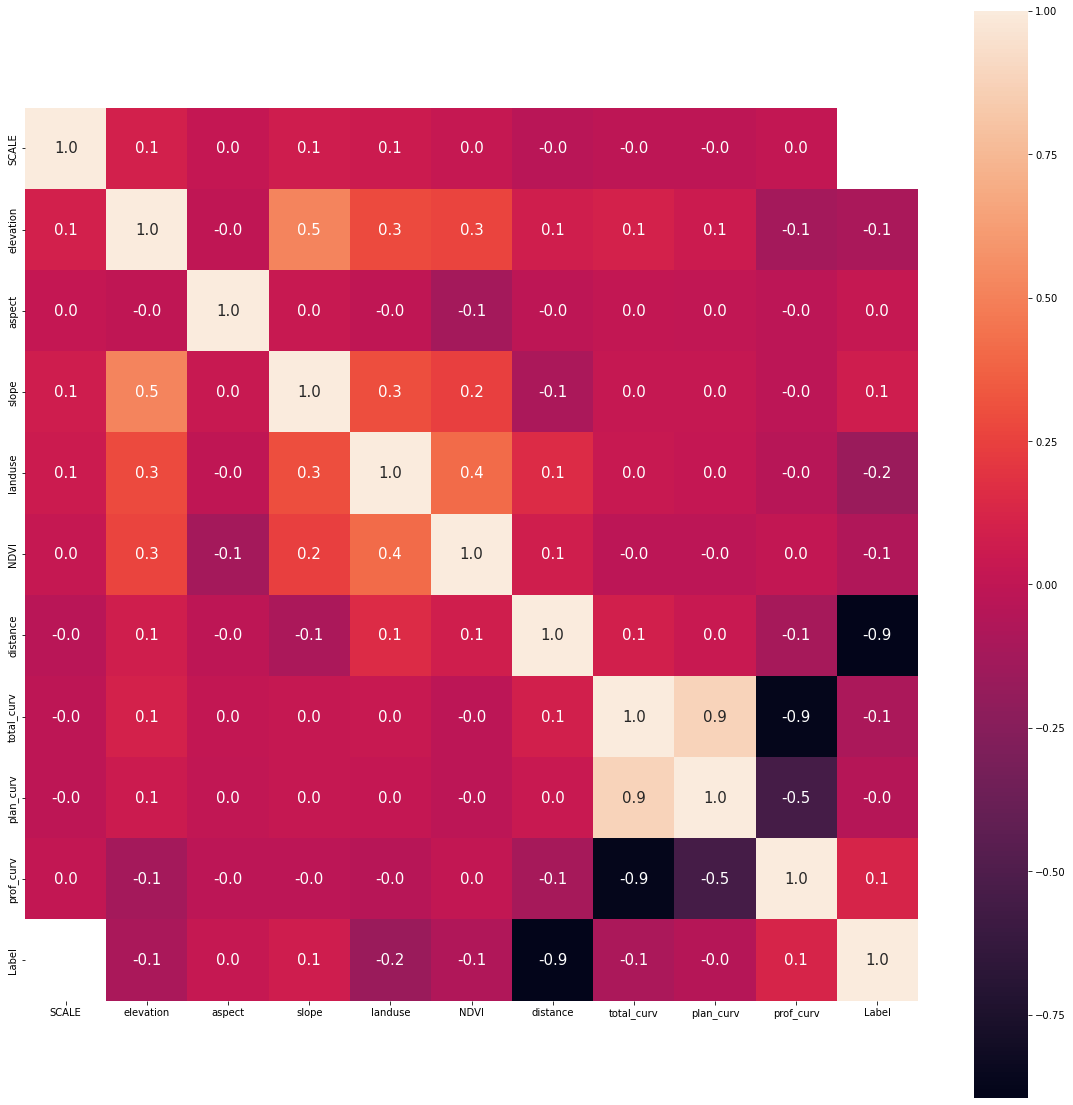

In [3]:
# low correlation
plt.figure(figsize=(20,20))
corr=data.corr()
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15})
data.head()
data.dtypes


## data process

In [4]:
#reclassify land use types
def landuse_cal(landuse_befo):
    if landuse_befo <= 54:
        return 'urban'
    elif landuse_befo == 72:
        return 'Shrubland'
    elif landuse_befo == 73 or landuse_befo == 81:
        return 'Grassland'
    elif landuse_befo == 71:
        return 'forest'
    elif landuse_befo == 61:
        return 'Agriculture'
    elif landuse_befo == 74:
        return 'Wetland'
    else :
        return 'water'

In [5]:
data['landuse'] = data['landuse'].apply(landuse_cal)
data.head()

,FEATTYPE,SCALE,FACAFF,elevation,aspect,slope,landuse,Period,Years_befo,Main_Rock_,NDVI,distance,total_curv,plan_curv,prof_curv,Label
0,Retaining Wall (Masonry),1.5,Minor footpath; other (platform above the reta...,52,330.524,2.04472,urban,Quaternary,0-1.8,"Superficial Deposits (Silt, sand and gravel)",0.193857,17.340808,-0.282579,-0.181710,0.100869,1
1,Fill Slope,18.0,Open area,1,225.000,1.86081,Agriculture,Quaternary,0-1.8,"Superficial Deposits (Silt, sand and gravel)",0.292597,51.054059,0.282579,0.289513,0.006934,1
2,Soil Cut,0.5,Minor footpath,6,149.534,3.05130,Shrubland,Quaternary,0-1.8,"Superficial Deposits (Silt, sand and gravel)",0.339637,130.601425,-0.208863,-0.102582,0.106281,1
3,Soil Cut,45.0,Access road,26,346.373,5.24349,urban,Quaternary,0-1.8,"Superficial Deposits (Silt, sand and gravel)",0.194702,384.036599,0.159719,0.161805,0.002086,1
4,Soil Cut,0.3,Other (alleyway),22,335.999,11.45630,urban,Quaternary,0-1.8,"Superficial Deposits (Silt, sand and gravel)",0.155207,370.113211,-0.651161,-0.205214,0.445947,1


In [6]:
df2 = pd.get_dummies(data, columns=['Main_Rock_','Period','FEATTYPE','FACAFF','landuse'])
df2.loc[df2['Label']==0,'SCALE']=0
#check na value
df2.isnull().sum()

# transfet the happening year to the lowest bar
def year_cal(Years_befo):
    if Years_befo == '0-1.8':
        return 1.8
    elif Years_befo == '145-199':
        return 145
    elif Years_befo == '359-416':
        return 359
    elif Years_befo == '65-145':
        return 65
    #Years_befo == '299-359'
    else :
        return 299
    
df2['Year'] = df2['Years_befo'].apply(year_cal)
df2

,SCALE,elevation,aspect,slope,Years_befo,NDVI,distance,total_curv,plan_curv,prof_curv,...,FACAFF_Water treatment plant,FACAFF_footpath,landuse_Agriculture,landuse_Grassland,landuse_Shrubland,landuse_Wetland,landuse_forest,landuse_urban,landuse_water,Year
0,1.5,52,330.5240,2.04472,0-1.8,0.193857,17.340808,-0.282579,-0.181710,0.100869,...,0,0,0,0,0,0,0,1,0,1.8
1,18.0,1,225.0000,1.86081,0-1.8,0.292597,51.054059,0.282579,0.289513,0.006934,...,0,0,1,0,0,0,0,0,0,1.8
2,0.5,6,149.5340,3.05130,0-1.8,0.339637,130.601425,-0.208863,-0.102582,0.106281,...,0,0,0,0,1,0,0,0,0,1.8
3,45.0,26,346.3730,5.24349,0-1.8,0.194702,384.036599,0.159719,0.161805,0.002086,...,0,0,0,0,0,0,0,1,0,1.8
4,0.3,22,335.9990,11.45630,0-1.8,0.155207,370.113211,-0.651161,-0.205214,0.445947,...,0,0,0,0,0,0,0,1,0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7477,0.0,251,101.6540,23.82310,65-145,0.380204,28740.799350,0.958313,0.460359,-0.497954,...,0,0,0,0,1,0,0,0,0,65.0
7478,0.0,199,10.4915,12.55170,65-145,0.318335,28743.914350,-0.159719,0.082707,0.242426,...,0,0,0,0,1,0,0,0,0,65.0
7479,0.0,169,121.8570,21.13720,65-145,0.344763,28747.365230,-0.430012,-0.373889,0.056123,...,0,0,0,0,1,0,0,0,0,65.0
7480,0.0,29,329.5340,3.05130,0-1.8,0.285900,28749.072030,-0.110575,-0.057461,0.053114,...,0,0,0,0,0,0,0,1,0,1.8


In [7]:
col= df2.columns[pd.np.r_[0:4,5:15,16:420]]
print(col)
#get x value
x = np.array(df2[col])
x.shape

Index(['SCALE', 'elevation', 'aspect', 'slope', 'NDVI', 'distance',
       'total_curv', 'plan_curv', 'prof_curv', 'Label',
       ...
       'FACAFF_Walking trail', 'FACAFF_Water treatment plant',
       'FACAFF_footpath', 'landuse_Agriculture', 'landuse_Grassland',
       'landuse_Shrubland', 'landuse_Wetland', 'landuse_forest',
       'landuse_urban', 'landuse_water'],
      dtype='object', length=418)


C:\Users\zheng\AppData\Local\Temp/ipykernel_2968/316648795.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  col= df2.columns[pd.np.r_[0:4,5:15,16:420]]


(7482, 418)

In [8]:
# get y value
y=np.array(df2['Label'])
y

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

## Principal Component Analysis

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=None)
dfx = pd.DataFrame(data=x)
dfx_pca = pca.fit(dfx)
dfx

dfx_trans = pca.transform(dfx)
dfx_trans = pd.DataFrame(data=dfx_trans)
dfx_trans.head(10)

finalDf = pd.concat([dfx_trans, df2['Label']], axis = 1)

In [10]:
finalDf.head()

,0,1,2,3,4,5,6,7,8,9,...,409,410,411,412,413,414,415,416,417,Label
0,-4.971638,5.969289,1.084585,-1.081409,-0.657415,-1.408760,0.285319,1.856487,-1.777949,0.704649,...,-5.030971e-09,8.080342e-15,-7.036906e-15,-7.762020e-15,-3.332837e-15,1.154784e-14,-2.308223e-14,-8.432924e-16,-2.029106e-14,1
1,-3.633424,3.008069,-1.216445,-1.121709,-0.661369,-0.948254,0.048316,1.705689,-1.146161,-1.888577,...,5.396274e-04,-1.892583e-15,1.647987e-17,7.025630e-17,-1.513113e-15,2.231505e-15,-1.037365e-15,-1.524171e-15,4.255927e-15,1
2,-2.288265,2.578977,0.863547,-0.496291,-0.357609,-0.922017,0.209930,1.757012,-1.867018,-1.481141,...,2.065500e-04,-1.842276e-15,6.826137e-16,-1.150989e-15,-4.122137e-15,1.593127e-15,-1.738193e-15,-2.318675e-15,4.571647e-15,1
3,-2.969051,3.635723,-1.208177,-1.047718,-0.765775,-0.838402,-0.095716,1.391278,-1.957376,-0.131112,...,4.503352e-04,-4.961309e-16,1.067722e-15,3.773024e-16,-2.000570e-15,1.417052e-15,-2.393918e-16,-8.988036e-16,4.911002e-15,1
4,-2.905256,5.127651,1.567687,-0.321691,-0.984168,-0.654891,0.073749,0.998646,-1.781306,1.241958,...,6.479259e-04,-6.380313e-15,1.067722e-15,-7.016956e-16,-3.034465e-15,8.341852e-16,3.157197e-16,-4.226003e-15,6.722053e-15,1


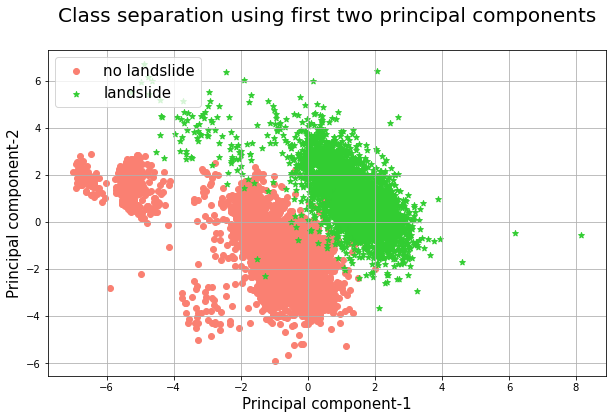

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
x0 = finalDf[finalDf['Label']==0]
x1 = finalDf[finalDf['Label']==1]

plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)

plt.scatter(x0[0], x0[1], c="salmon", marker='o', label='no landslide')
plt.scatter(x1[0], x1[1], c="limegreen", marker='*', label='landslide')

plt.legend(loc=2, prop = {'size':15})
ax.grid(True)

### Data Splitting

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [14]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 4)


##  1. k-Nearest Neighbor

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn= KNeighborsClassifier(n_neighbors=5)

In [29]:
# We need to do feature scaling first.
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
sc = StandardScaler()
#sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [30]:
knn.fit(X_train,y_train)


KNeighborsClassifier()

In [31]:
knn_pred=knn.predict(X_test)
knn_proba = knn.predict_proba(X_test)

In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,knn_pred)

0.9625835189309577

Performance metrics

In [33]:
knn_conf_mat = confusion_matrix(y_test, knn_pred)
knn_acc = accuracy_score(y_test, knn_pred)
knn_roc_auc = roc_auc_score(y_test, knn_proba[:,1])

knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_proba[:,1])
knn_precision, knn_recall, _ = precision_recall_curve(y_test, knn_proba[:,1])

knn_cls_precision, knn_cls_recall, knn_cls_f1, _ = precision_recall_fscore_support(y_test, knn_pred, average=None, labels=[0,1])

print('k Nearest Neighbors:')
print('\nConfusion matrix:\n',knn_conf_mat,'\n')
print('Accuracy:',knn_acc)
print('ROC AUC=%.4f' % (knn_roc_auc))
print('Precision on (Landslide = 0) = %.4f ' % (knn_cls_precision[0]))
print('Recall on (Landslide = 0) = %.4f ' % (knn_cls_recall[0]))
print('F1 on (Landslide = 0) = %.4f' % (knn_cls_f1[0]))
print('Precision on (Landslide = 1) = %.4f ' % (knn_cls_precision[1]))
print('Recall on (Landslide = 1) = %.4f ' % (knn_cls_recall[1]))
print('F1 on (Landslide = 1) = %.4f ' % (knn_cls_f1[1]))

k Nearest Neighbors:

Confusion matrix:
 [[1142    0]
 [  84 1019]] 

Accuracy: 0.9625835189309577
ROC AUC=0.9828
Precision on (Landslide = 0) = 0.9315 
Recall on (Landslide = 0) = 1.0000 
F1 on (Landslide = 0) = 0.9645
Precision on (Landslide = 1) = 1.0000 
Recall on (Landslide = 1) = 0.9238 
F1 on (Landslide = 1) = 0.9604 


In [23]:
knn_fpr

array([0., 0., 0., 0., 0., 1.])

In [24]:
knn_tpr

array([0.        , 0.88576609, 0.92384406, 0.9456029 , 0.9655485 ,
       1.        ])

In [25]:
_

array([1142, 1103], dtype=int64)

In [26]:
knn_proba[:,1]

array([0.4, 1. , 0.2, ..., 1. , 1. , 1. ])

In [27]:
len(knn_proba[:,1])

2245

In [28]:
y_test

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

## 2. Support Vector Machine

Hyperparameter optimization

In [72]:
np.logspace(-3,3,7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [73]:
model = SVC(kernel='sigmoid',random_state=0, probability=True)

param_grid={'C':np.logspace(-3,3,7),
            'kernel': [ 'rbf', 'sigmoid']
           }

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

C = grid.best_estimator_.C
kernel = grid.best_estimator_.kernel

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 1.0
Best hyperparameters: {'C': 0.1, 'kernel': 'sigmoid'}


Train on opmtimal hyperparameters

In [77]:
svm = SVC(random_state =0, probability = True,C=C,kernel = kernel).fit(X_train,y_train.ravel())

Get predictions and probabilities on test set

In [78]:
svm_pred = svm.predict(X_test)
svm_proba = svm.predict_proba(X_test)

Performance metrics

In [79]:
svm_conf_mat = confusion_matrix(y_test, svm_pred)
svm_acc = accuracy_score(y_test, svm_pred)
svm_roc_auc = roc_auc_score(y_test, svm_proba[:,1])

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_proba[:,1])
svm_precision, svm_recall, _ = precision_recall_curve(y_test, svm_proba[:,1])

svm_cls_precision, svm_cls_recall, svm_cls_f1, _ = precision_recall_fscore_support(y_test, svm_pred, average=None, labels=[0,1])
print('Support Vector Machine :')
print('\nConfusion matrix:\n',svm_conf_mat,'\n')
print('Accuracy:',svm_acc)
print('ROC AUC=%.4f' % (svm_roc_auc))
print('Precision on (Landslide = 0) = %.4f ' % (svm_cls_precision[0]))
print('Recall on (Landslide = 0) = %.4f ' % (svm_cls_recall[0]))
print('F1 on (Landslide = 0) = %.4f' % (svm_cls_f1[0]))
print('Precision on (Landslide = 1) = %.4f ' % (svm_cls_precision[1]))
print('Recall on (Landslide = 1) = %.4f ' % (svm_cls_recall[1]))
print('F1 on (Landslide = 1) = %.4f ' % (svm_cls_f1[1]))

Support Vector Machine :

Confusion matrix:
 [[1142    0]
 [   0 1103]] 

Accuracy: 1.0
ROC AUC=1.0000
Precision on (Landslide = 0) = 1.0000 
Recall on (Landslide = 0) = 1.0000 
F1 on (Landslide = 0) = 1.0000
Precision on (Landslide = 1) = 1.0000 
Recall on (Landslide = 1) = 1.0000 
F1 on (Landslide = 1) = 1.0000 


## 3. Artificial Neural Network

In [ ]:
model = MLPClassifier(random_state=0, max_iter=1000)

param_grid={
            'hidden_layer_sizes': np.arange(10, 50,5),
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'alpha' : 10.0 ** -np.arange(1, 5),
            'learning_rate': ['constant', 'adaptive']
           }

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

hidden_layer_sizes = grid.best_estimator_.hidden_layer_sizes
activation = grid.best_estimator_.activation
alpha = grid.best_estimator_.alpha
learning_rate = grid.best_estimator_.learning_rate

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [58]:
mlp = MLPClassifier(random_state=0, max_iter = 1000, activation = activation, alpha = alpha, hidden_layer_sizes = hidden_layer_sizes, learning_rate=learning_rate).fit(X_train,y_train.ravel())

In [59]:
mlp_pred = mlp.predict(X_test)
mlp_proba = mlp.predict_proba(X_test)

In [60]:
mlp_conf_mat = confusion_matrix(y_test, mlp_pred)
mlp_acc = accuracy_score(y_test, mlp_pred)
mlp_roc_auc = roc_auc_score(y_test, mlp_proba[:,1])

mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_proba[:,1])
mlp_precision, mlp_recall, _ = precision_recall_curve(y_test, mlp_proba[:,1])

mlp_cls_precision, mlp_cls_recall, mlp_cls_f1, _ = precision_recall_fscore_support(y_test, mlp_pred, average=None, labels=[0,1])

print('Multi Layer Perceptron :')
print('\nConfusion matrix:\n',mlp_conf_mat,'\n')
print('Accuracy:',mlp_acc)
print('ROC AUC=%.4f' % (mlp_roc_auc))
print('Precision on (Landslide = 0) = %.4f ' % (mlp_cls_precision[0]))
print('Recall on (Landslide = 0) = %.4f ' % (mlp_cls_recall[0]))
print('F1 on (Landslide = 0) = %.4f' % (mlp_cls_f1[0]))
print('Precision on (Landslide = 1) = %.4f ' % (mlp_cls_precision[1]))
print('Recall on (Landslide = 1) = %.4f ' % (mlp_cls_recall[1]))
print('F1 on (Landslide = 1) = %.4f ' % (mlp_cls_f1[1]))

Multi Layer Perceptron :

Confusion matrix:
 [[1142    0]
 [   1 1102]] 

Accuracy: 0.999554565701559
ROC AUC=1.0000
Precision on (Landslide = 0) = 0.9991 
Recall on (Landslide = 0) = 1.0000 
F1 on (Landslide = 0) = 0.9996
Precision on (Landslide = 1) = 1.0000 
Recall on (Landslide = 1) = 0.9991 
F1 on (Landslide = 1) = 0.9995 


## 4. Random Forest

In [61]:
model = RandomForestClassifier(random_state=0)

param_grid = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(10,30,2),
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

n_estimators = grid.best_estimator_.n_estimators
criterion = grid.best_estimator_.criterion
max_depth = grid.best_estimator_.max_depth
max_features = grid.best_estimator_.max_features

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 1.0
Best hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}


In [62]:
rf = RandomForestClassifier(random_state=0, criterion=criterion, max_depth=max_depth, max_features=max_features, n_estimators = n_estimators).fit(X_train,y_train.ravel())

In [63]:
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)

In [64]:
rf_conf_mat = confusion_matrix(y_test, rf_pred)
rf_acc = accuracy_score(y_test, rf_pred)
rf_roc_auc = roc_auc_score(y_test, rf_proba[:,1])

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba[:,1])
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_proba[:,1])

rf_cls_precision, rf_cls_recall, rf_cls_f1, _ = precision_recall_fscore_support(y_test, rf_pred, average=None, labels=[0,1])

print('Random Forest :')
print('\nConfusion matrix:\n',rf_conf_mat,'\n')
print('Accuracy:',rf_acc)
print('ROC AUC=%.4f' % (rf_roc_auc))
print('Precision on (Landslide = 0) = %.4f ' % (rf_cls_precision[0]))
print('Recall on (Landslide = 0) = %.4f ' % (rf_cls_recall[0]))
print('F1 on (Landslide = 0) = %.4f' % (rf_cls_f1[0]))
print('Precision on (Landslide = 1) = %.4f ' % (rf_cls_precision[1]))
print('Recall on (Landslide = 1) = %.4f ' % (rf_cls_recall[1]))
print('F1 on (Landslide = 1) = %.4f ' % (rf_cls_f1[1]))

Random Forest :

Confusion matrix:
 [[1142    0]
 [   0 1103]] 

Accuracy: 1.0
ROC AUC=1.0000
Precision on (Landslide = 0) = 1.0000 
Recall on (Landslide = 0) = 1.0000 
F1 on (Landslide = 0) = 1.0000
Precision on (Landslide = 1) = 1.0000 
Recall on (Landslide = 1) = 1.0000 
F1 on (Landslide = 1) = 1.0000 


## 5. decision tree

In [65]:
model = DecisionTreeClassifier(random_state=0)

param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(10,40,5),
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid.fit(X_train, y_train.ravel())

criterion = grid.best_estimator_.criterion
max_depth = grid.best_estimator_.max_depth
max_features = grid.best_estimator_.max_features

# summarize the results of the grid search
print('Best score:', grid.best_score_)
print('Best hyperparameters:',grid.best_params_)

Best score: 0.9931252141706219
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto'}


In [66]:
dt = DecisionTreeClassifier(random_state=0, criterion = criterion, max_depth=max_depth, max_features=max_features).fit(X_train, y_train.ravel())

In [67]:
dt_pred = dt.predict(X_test)
dt_proba = dt.predict_proba(X_test)

In [68]:
dt_conf_mat = confusion_matrix(y_test, dt_pred)
dt_acc = accuracy_score(y_test, dt_pred)
dt_roc_auc = roc_auc_score(y_test, dt_proba[:,1])

dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_proba[:,1])
dt_precision, dt_recall, _ = precision_recall_curve(y_test, dt_proba[:,1])

dt_cls_precision, dt_cls_recall, dt_cls_f1, _ = precision_recall_fscore_support(y_test, dt_pred, average=None, labels=[0,1])

print('Decision Tree:')
print('\nConfusion matrix:\n',dt_conf_mat,'\n')
print('Accuracy:',dt_acc)
print('ROC AUC=%.4f' % (dt_roc_auc))
print('Precision on (Landslide = 0) = %.4f ' % (dt_cls_precision[0]))
print('Recall on (Landslide = 0) = %.4f ' % (dt_cls_recall[0]))
print('F1 on (Landslide = 0) = %.4f' % (dt_cls_f1[0]))
print('Precision on (Landslide = 1) = %.4f ' % (dt_cls_precision[1]))
print('Recall on (Landslide = 1) = %.4f ' % (dt_cls_recall[1]))
print('F1 on (Landslide = 1) = %.4f ' % (dt_cls_f1[1]))

Decision Tree:

Confusion matrix:
 [[1131   11]
 [  88 1015]] 

Accuracy: 0.955902004454343
ROC AUC=0.9647
Precision on (Landslide = 0) = 0.9278 
Recall on (Landslide = 0) = 0.9904 
F1 on (Landslide = 0) = 0.9581
Precision on (Landslide = 1) = 0.9893 
Recall on (Landslide = 1) = 0.9202 
F1 on (Landslide = 1) = 0.9535 


## Export performance metrics of models

In [82]:
perf_metr = pd.DataFrame(index = ['K Nearest Neighbors',
                        'Support Vector Machine',
                        'Multi Layer Perceptron',
                        'Decision Tree',
                        'Random Forest',
                       ],
             columns = ['Accuracy', 
                        'ROC AUC', 
                        'Precision on Landlside=0', 
                        'Recall on Landlside=0', 
                        'F1-score on Landlside=0', 
                        'Precision on Landlside=1', 
                        'Recall on Landlside=1', 
                        'F1-score on Landlside=1']
            )

In [83]:
knn_perf_metr = pd.Series([knn_acc, knn_roc_auc, knn_cls_precision[0], knn_cls_recall[0], knn_cls_f1[0], knn_cls_precision[0],knn_cls_recall[0], knn_cls_f1[0]])
svm_perf_metr = pd.Series([svm_acc, svm_roc_auc, svm_cls_precision[0], svm_cls_recall[0], svm_cls_f1[0], svm_cls_precision[0],svm_cls_recall[0], svm_cls_f1[0]])
mlp_perf_metr = pd.Series([mlp_acc, mlp_roc_auc, mlp_cls_precision[0], mlp_cls_recall[0], mlp_cls_f1[0], mlp_cls_precision[0],mlp_cls_recall[0], mlp_cls_f1[0]])
dt_perf_metr = pd.Series([dt_acc, dt_roc_auc, dt_cls_precision[0], dt_cls_recall[0], dt_cls_f1[0], dt_cls_precision[0],dt_cls_recall[0], dt_cls_f1[0]])
rf_perf_metr = pd.Series([rf_acc, rf_roc_auc, rf_cls_precision[0], rf_cls_recall[0], rf_cls_f1[0], rf_cls_precision[0],rf_cls_recall[0], rf_cls_f1[0]])

In [84]:
perf_metr.loc['K Nearest Neighbors',:] = knn_perf_metr.values
perf_metr.loc[ 'Support Vector Machine',:] = svm_perf_metr.values
perf_metr.loc['Multi Layer Perceptron',:] = mlp_perf_metr.values
perf_metr.loc['Decision Tree',:] = dt_perf_metr.values
perf_metr.loc['Random Forest',:] = rf_perf_metr.values

In [85]:
perf_metr = perf_metr.astype(float).round(4)

In [86]:
perf_metr

,Accuracy,ROC AUC,Precision on Landlside=0,Recall on Landlside=0,F1-score on Landlside=0,Precision on Landlside=1,Recall on Landlside=1,F1-score on Landlside=1
K Nearest Neighbors,0.9626,0.9828,0.9315,1.0000,0.9645,0.9315,1.0000,0.9645
Support Vector Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Multi Layer Perceptron,0.9996,1.0000,0.9991,1.0000,0.9996,0.9991,1.0000,0.9996
Decision Tree,0.9559,0.9647,0.9278,0.9904,0.9581,0.9278,0.9904,0.9581
Random Forest,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


## ROC-AUC curves

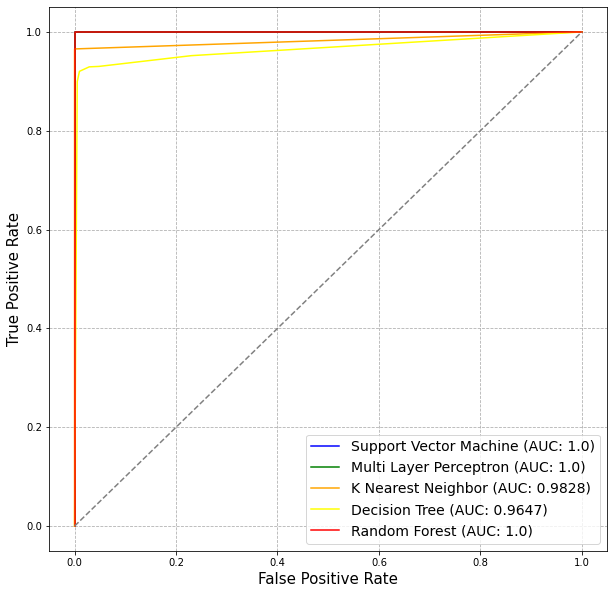

In [89]:

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_proba[:,1])
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_proba[:,1])
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba[:,1])

fig, ax = plt.subplots(1, figsize=(10,10))

# fig.figure(figsize=(10,10))

# plot the roc curve for the model
# pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax.plot(svm_fpr, svm_tpr,  color = 'blue', label='Support Vector Machine (AUC: ' + str(np.round(svm_roc_auc,4))+')')
ax.plot(mlp_fpr, mlp_tpr, color = 'green', label='Multi Layer Perceptron (AUC: ' + str(np.round(mlp_roc_auc,4))+')')
ax.plot(knn_fpr, knn_tpr,  color = 'orange',label='K Nearest Neighbor (AUC: ' + str(np.round(knn_roc_auc,4))+')')
ax.plot(dt_fpr, dt_tpr,  color = 'yellow', label='Decision Tree (AUC: ' + str(np.round(dt_roc_auc,4))+')')
ax.plot(rf_fpr, rf_tpr,  color = 'red', label='Random Forest (AUC: ' + str(np.round(rf_roc_auc,4))+')')
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')

# axis labels
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_ylabel('True Positive Rate', fontsize=15)

# show the legend
# plt.legend()

handles,labels = ax.get_legend_handles_labels()


handles = [handles[0], handles[1], handles[2], handles[3], handles[4]]
labels = [labels[0], labels[1], labels[2], labels[3], labels[4]]

ax.grid(linestyle='dashed')
ax.legend(handles,labels, fontsize=14)

plt.show()

### deep learning model

## 1. CNN 

In [15]:
print(X_train.shape)
print(y_train.shape)

(5237, 418)
(5237,)


In [ ]:
model = Sequential()
model.add(Dense(80, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(80, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,epochs=20)


In [ ]:
results = model.evaluate(X_test, y_test, batch_size=128)